# Epicardial cell analysis

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [3]:
import anndata as ad
import scanpy as sc
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cellrank as cr
import scvelo as scv

In [4]:
from cellrank.tl.kernels import PseudotimeKernel, ConnectivityKernel, VelocityKernel
from cellrank.tl.estimators import GPCCA

In [5]:
scv.set_figure_params()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

In [6]:
from utils import *

In [7]:
my_cmap = get_continuous_cmap(['D6D6D6', '5D4FF4'])

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [8]:
cr.logging.print_versions()

cellrank==1.5.1 scanpy==1.9.1 anndata==0.8.0 numpy==1.22.4 numba==0.55.2 scipy==1.9.0 pandas==1.4.3 pygpcca==1.0.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


In [9]:
cr.logging.print_version_and_date()

Running CellRank 1.5.1, on 2022-11-24 22:35.


## Setup paths

In [10]:
data_path = '/lustre/groups/ml01/workspace/laura.martens/moretti_colab'
save_path = os.path.join(data_path, 'biological_analysis')
scvelo_path = os.path.join(data_path, 'scvelo')

In [11]:
fig_path = '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels'
fig_path = os.path.join(fig_path, 'epicardial')
sc.settings.figdir = fig_path

# Load data

In [12]:
adata = sc.read('/lustre/groups/ml01/workspace/laura.martens/moretti_colab/scglue/metacells_imputed.h5ad')

In [13]:
# Load scvelo results
scvelo_adata = sc.read(os.path.join(scvelo_path, 'scvelo_adata_non_dl.h5ad'))

In [14]:
scvelo_adata = scvelo_adata[adata.obs_names].copy()

In [15]:
scvelo_adata.obsm['X_umap'] = adata.obsm['X_umap']
scvelo_adata.obsm['X_glue'] = adata.obsm['X_glue']
scvelo_adata.obs = scvelo_adata.obs.join(adata.obs.leiden_res1)

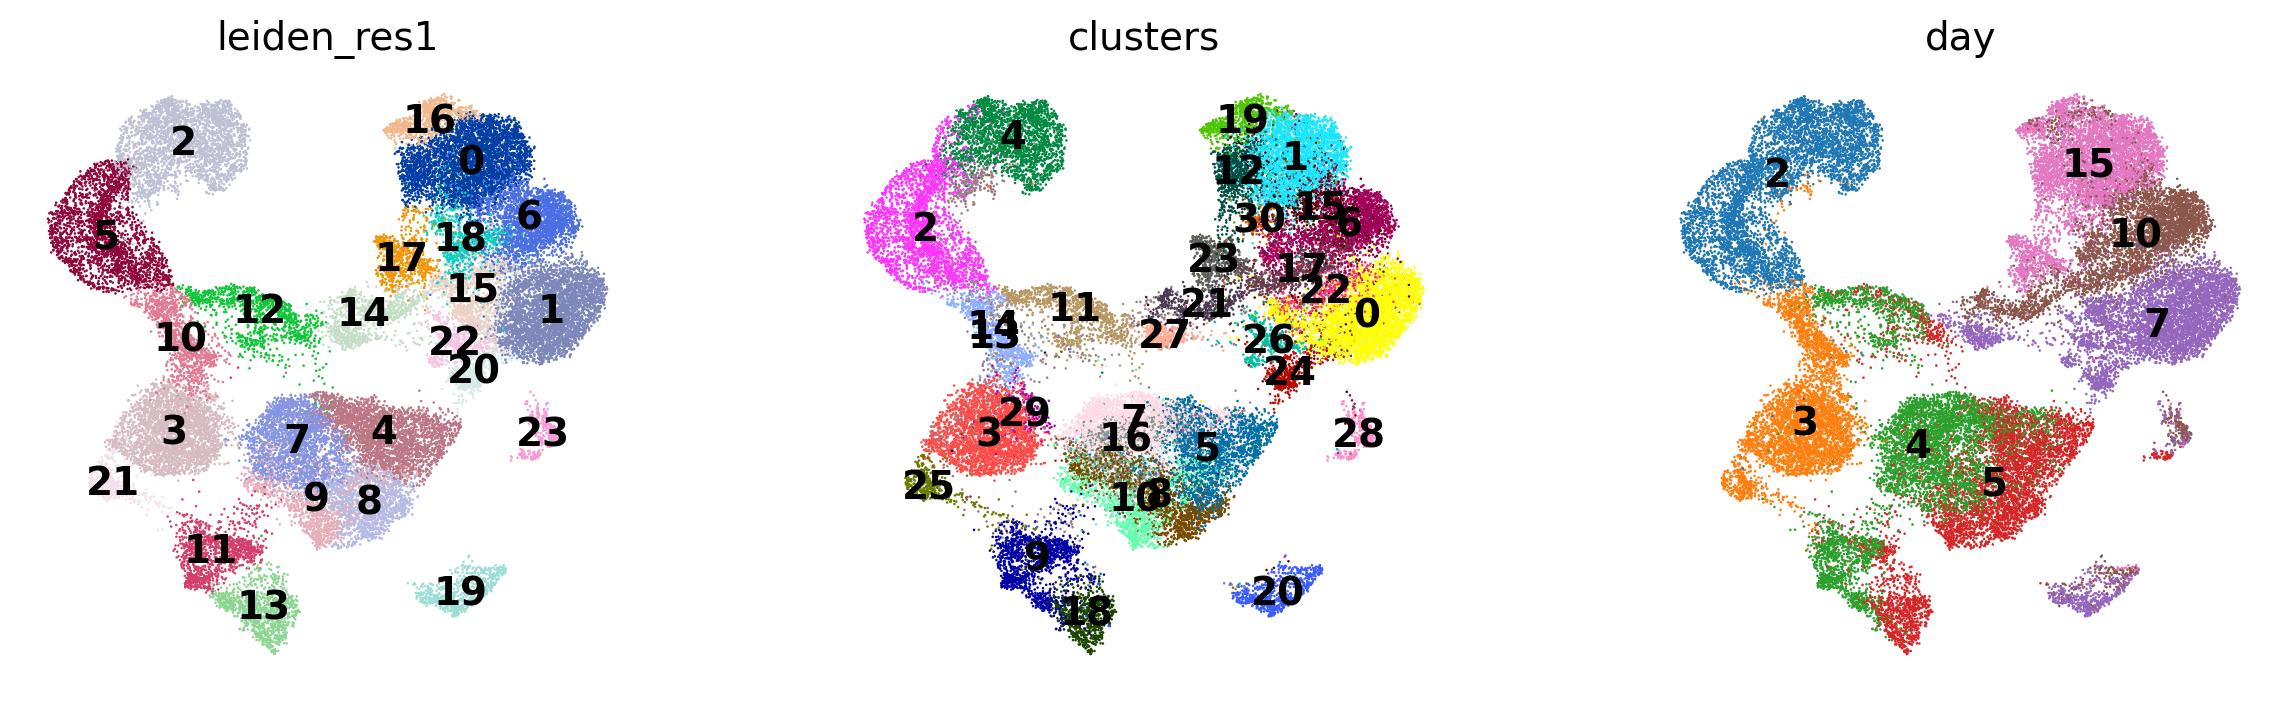

In [16]:
sc.pl.umap(adata, color=['leiden_res1', 'clusters', 'day'], legend_loc='on data')

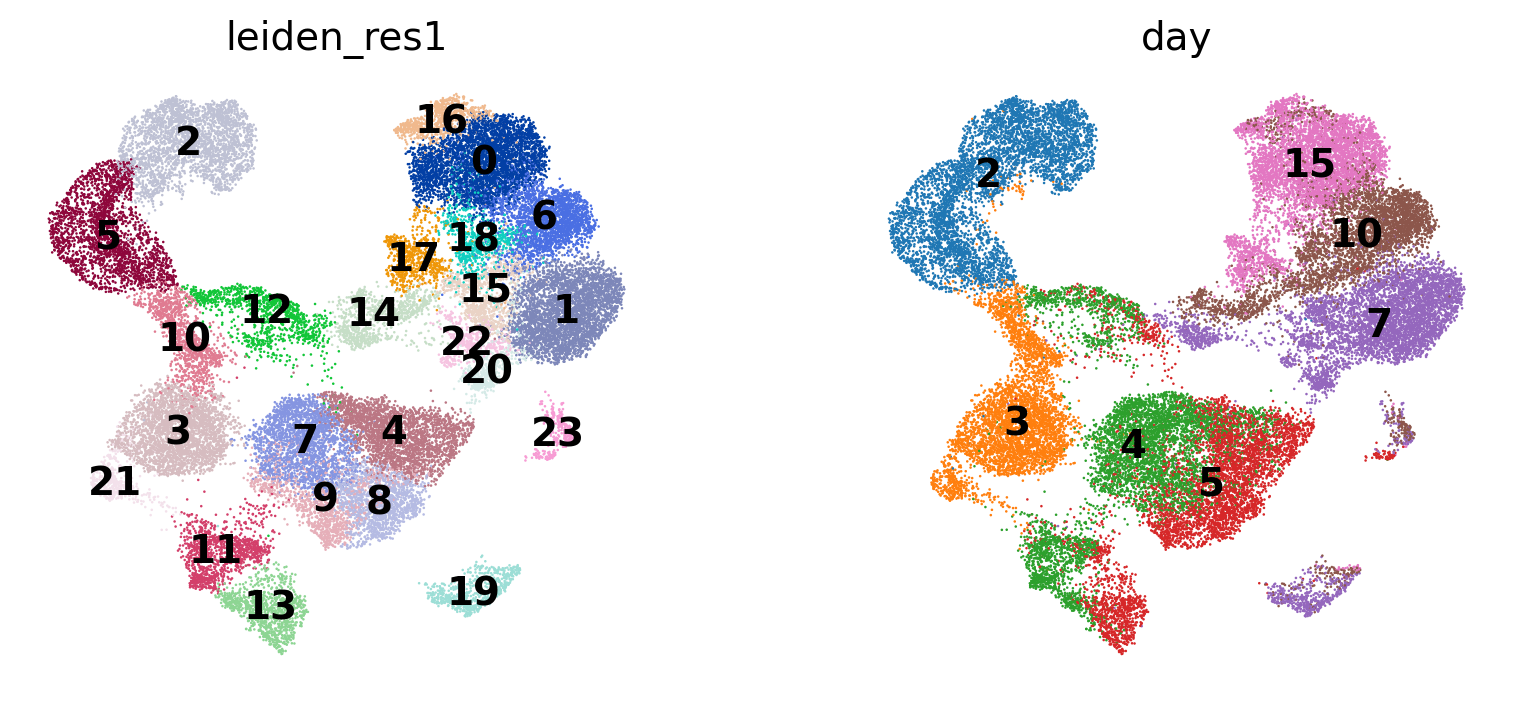

In [17]:
sc.pl.umap(adata, color=['leiden_res1', 'day'], legend_loc='on data')

## Load markers

In [19]:
markers_act = pd.read_excel(os.path.join(data_path, 'transfer_data', 'Epicardial_trajectories.xlsx'))['Imputed gene activity'].dropna()
markers_exp = pd.read_excel(os.path.join(data_path, 'transfer_data', 'Epicardial_trajectories.xlsx'))['Gene expression'].dropna()

# Load overall cellrank results

In [23]:
g = GPCCA.read(os.path.join(data_path, 'cellrank', 'g.pickle'))

In [24]:
#add pseudotime
adata.obs = adata.obs.join(g.adata.obs.pr_pseudotime)

In [25]:
scvelo_adata.obs = scvelo_adata.obs.join(g.adata.obs.pr_pseudotime)

# Restrict to JCF and Epicardial at day 15

In [26]:
cluster = ['17', '14'] 
adata_epi = adata[adata.obs.leiden_res1.isin(cluster)].copy()

In [27]:
# also restrict to day 15
adata_epi = adata_epi[adata_epi.obs.day == '15']

In [28]:
adata_epi_scvelo = scvelo_adata[adata_epi.obs_names]

## Plot markers in gene expression space

In [29]:
sc.pp.neighbors(adata_epi, use_rep='X_glue')
sc.tl.umap(adata_epi)

In [30]:
sc.tl.leiden(adata_epi, resolution=0.7, key_added='leiden_sub')

In [31]:
sc.tl.leiden(adata_epi, resolution=0.4, restrict_to=('leiden_sub', ["0"]), key_added="leiden_sub")

In [32]:
adata_epi.obs.leiden_sub = adata_epi.obs.leiden_sub.replace({'0,2': "0", '0,1': "7", '0,0': "7"})

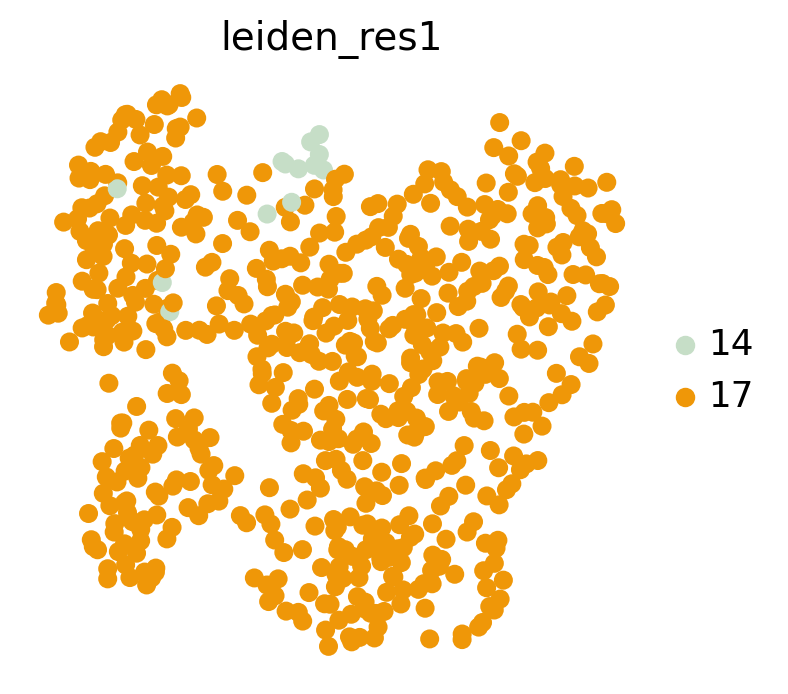

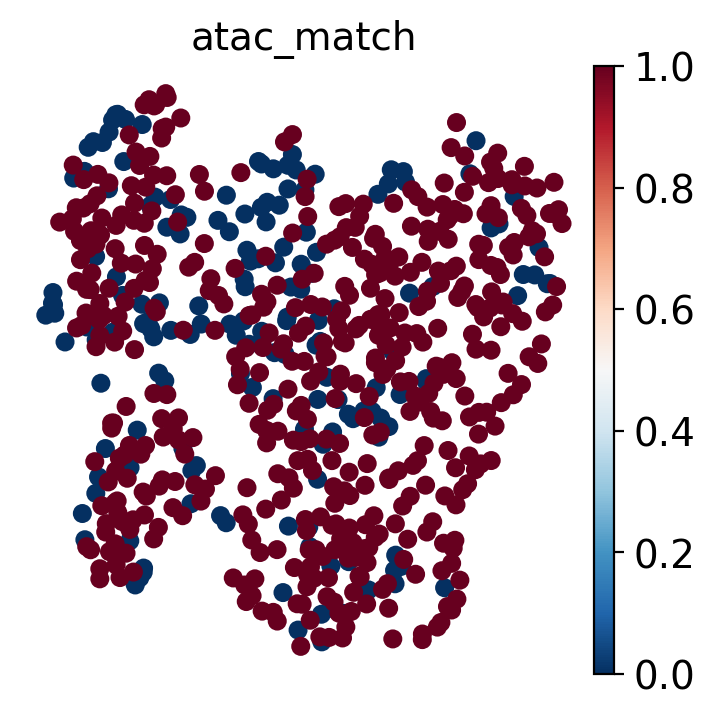

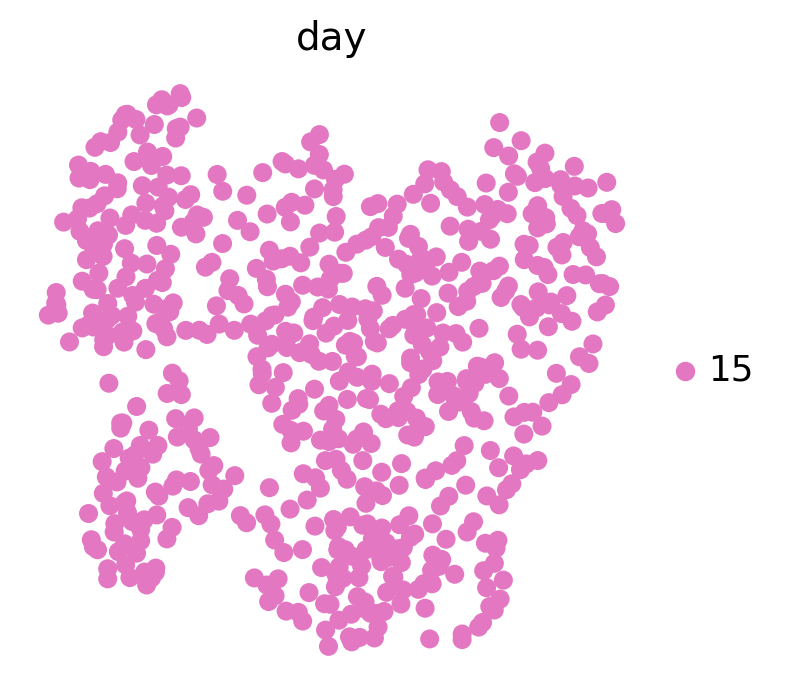

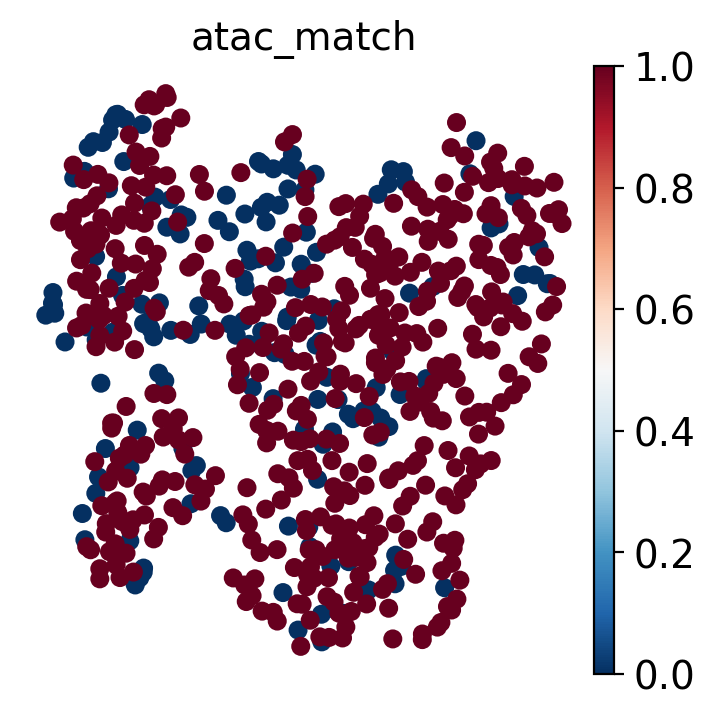

In [32]:
for key in ['leiden_res1', 'atac_match', 'day', 'atac_match']:
    sc.pl.umap(adata_epi, color=[key], save=f'epi_{key}.pdf')

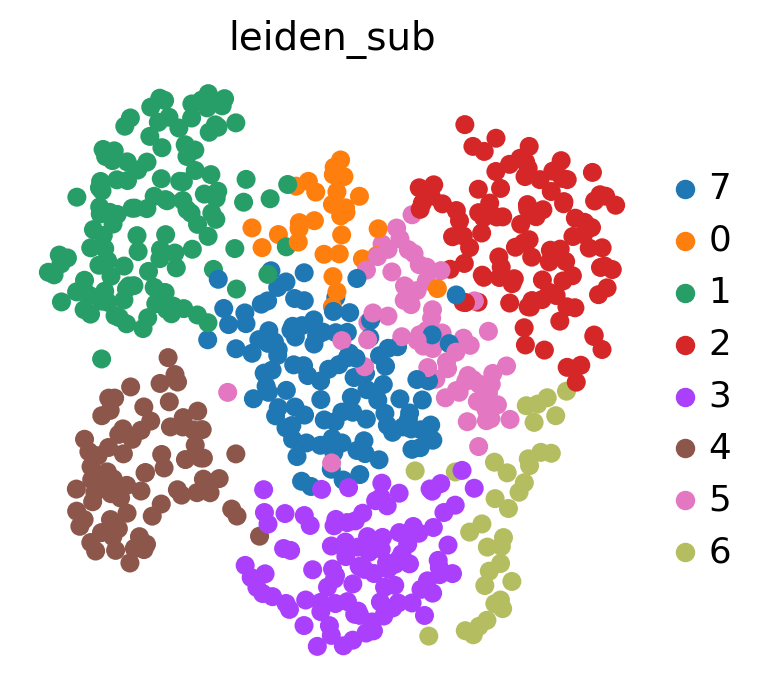

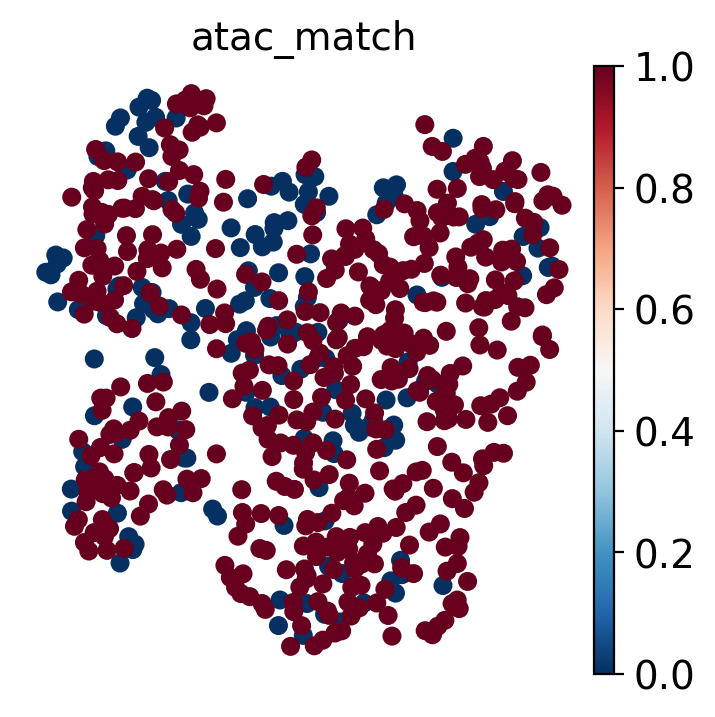

In [ ]:
for key in ['leiden_sub', 'atac_match']:
    sc.pl.umap(adata_epi, color=[key], save=f'epi_{key}.pdf')

### Save data

In [ ]:
adata_epi.write(os.path.join(save_path, 'adata_epi.h5ad'))

## Perform DE testing for new subclusters

In [41]:
adata_epi.uns['log1p']['base'] = None

In [42]:
#exclude RP and MT genes for DE testing
adata_epi = adata_epi[:, ~adata_epi.var_names.str.contains('RP|MT-', regex=True)].copy()

In [43]:
sc.tl.rank_genes_groups(adata_epi, groupby='leiden_sub', layer='log_counts', method='wilcoxon')

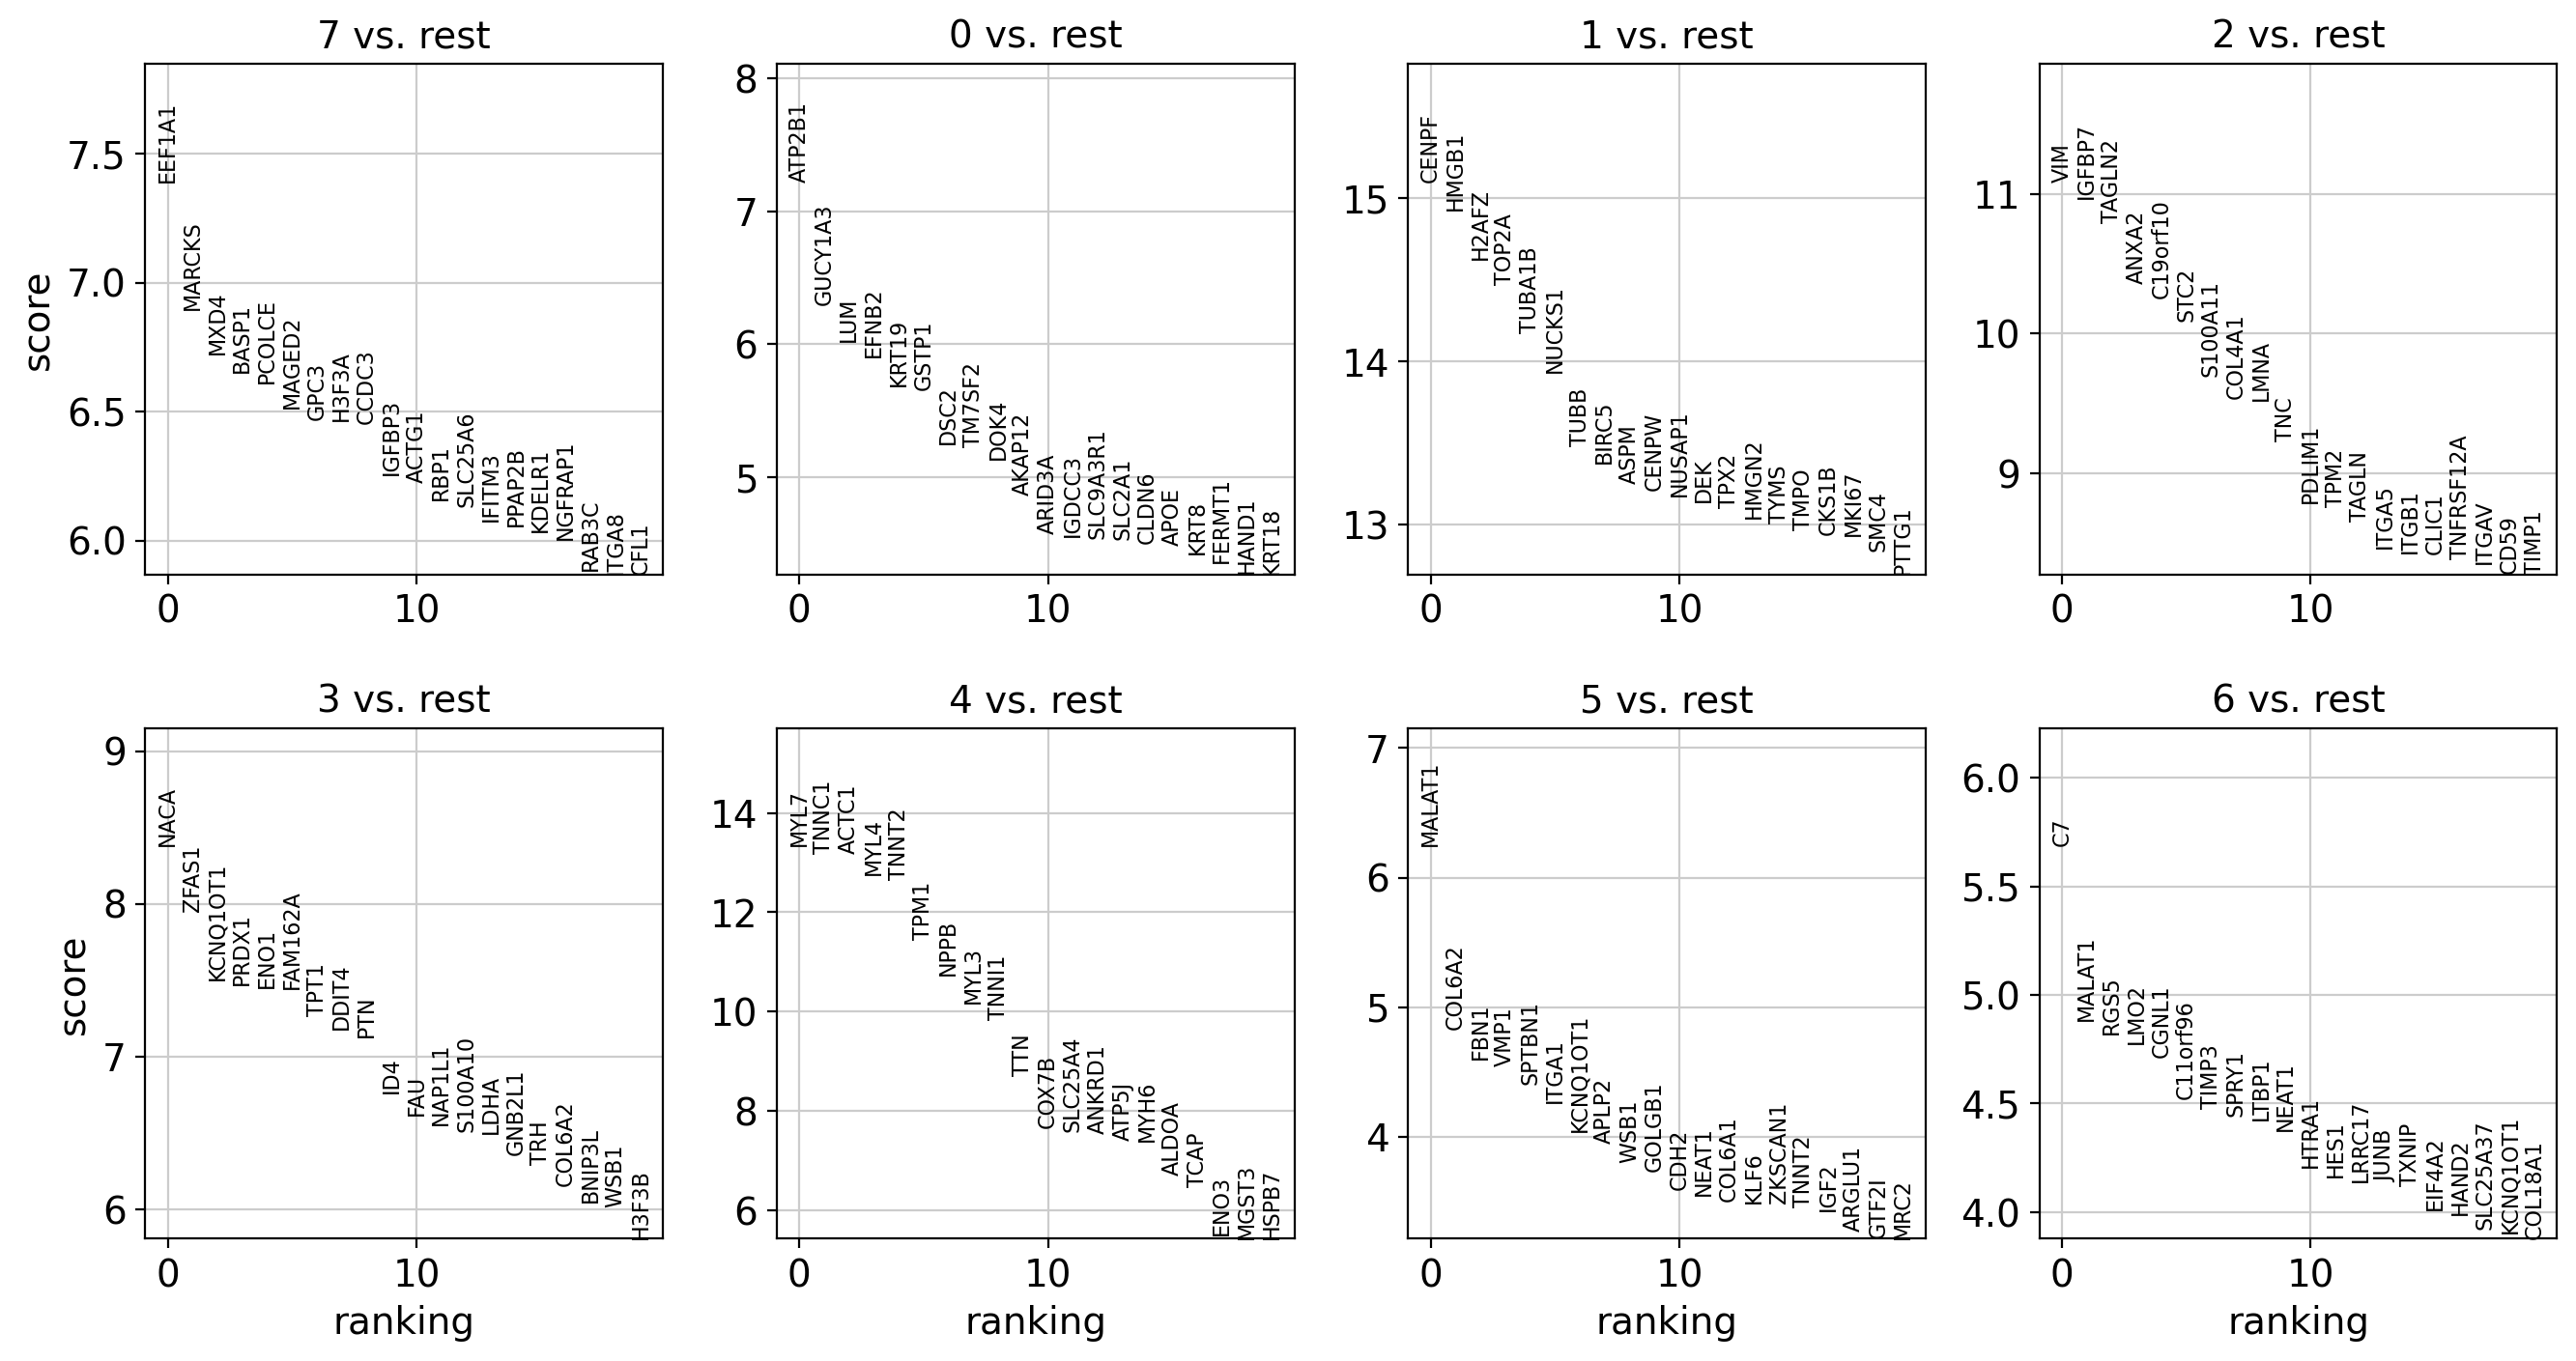

In [44]:
sc.pl.rank_genes_groups(adata_epi, sharey=False)

## Save deg

In [ ]:
for cluster in adata_epi.obs.leiden_sub.unique():
    df = pd.DataFrame({key: item[cluster] for key, item in adata_epi.uns['rank_genes_groups'].items()}).head(100)
    df.to_csv(os.path.join(fig_path, f'top_100_deg_cluster_{cluster}.csv'))

## Run cellrank on this subset

In [33]:
sc.pp.neighbors(adata_epi_scvelo, use_rep='X_glue')

In [34]:
adata_epi_scvelo.obsm['X_umap'] = adata_epi.obsm['X_umap']

In [35]:
adata_epi_scvelo.obs = adata_epi_scvelo.obs.join(adata_epi.obs.leiden_sub)

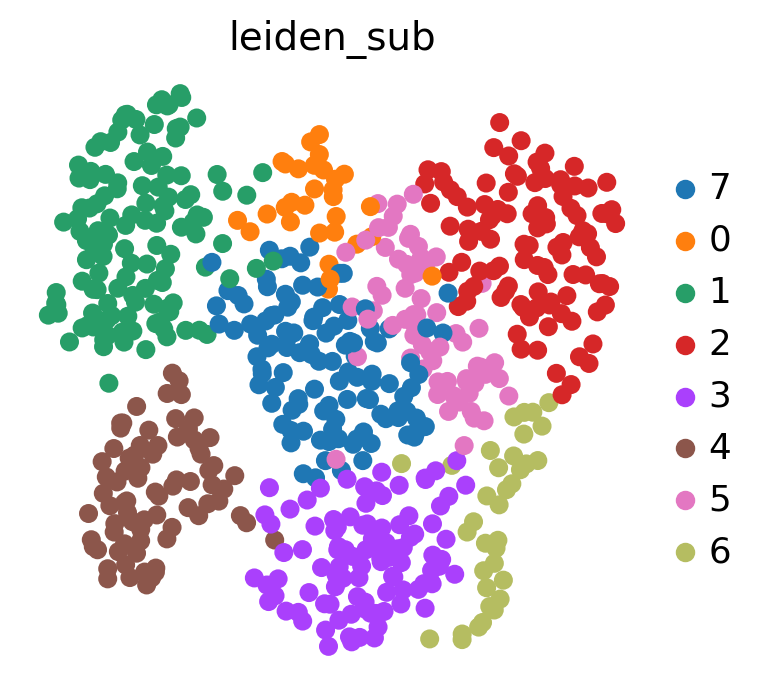

In [36]:
sc.pl.umap(adata_epi_scvelo, color='leiden_sub')

In [37]:
pk = PseudotimeKernel(adata_epi, time_key='pr_pseudotime') 

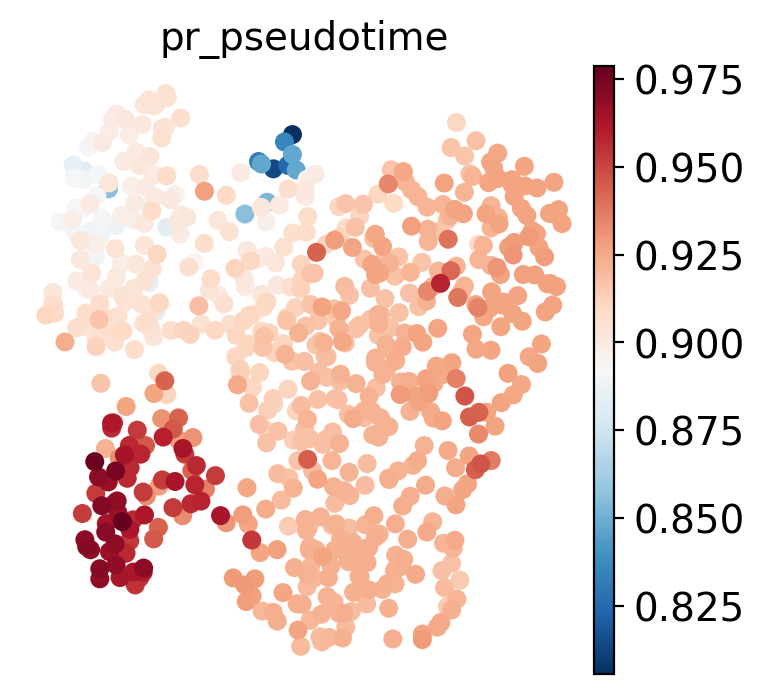

In [38]:
sc.pl.umap(adata_epi, color='pr_pseudotime')

In [39]:
pk.compute_transition_matrix()

  0%|          | 0/640 [00:00<?, ?cell/s]

<PseudotimeKernel>

In [40]:
vk = VelocityKernel(adata_epi_scvelo)

In [41]:
vk.compute_transition_matrix()

  0%|          | 0/640 [00:00<?, ?cell/s]

  0%|          | 0/640 [00:00<?, ?cell/s]

<VelocityKernel>

In [42]:
k = 0.3*vk + 0.7*pk

In [43]:
g = GPCCA(k)
print(g)

GPCCA[n=640, kernel=((0.3 * <VelocityKernel[softmax_scale=18.09, mode=deterministic, seed=48562, scheme=<CorrelationScheme>]>) + (0.7 * <PseudotimeKernel[dnorm=False, scheme=hard, frac_to_keep=0.3]>))]


In [44]:
g.compute_schur(n_components=30)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000036e+00 6.2395398826774161e-03 -2.0982385517548427e-02 4.1787952466867333e-02 -1.8120604791844318e-02 -3.2603316798292532e-03 -1.1594777283557832e-02 1.1155384165760550e-02 -2.0448219865873151e-02 -9.2438889388309561e-03 1.8574597208374632e-02 -2.1581874299137896e-02 -2.2964202592352250e-02 1.8685227377959638e-02 1.3448502062419140e-02 9.8855303578672515e-03 -1.2137204700042504e-02 -1.6010413533071463e-02 3.8666846173742910e-03 1.7710704774623772e-03 1.5060040907778330e-02 -6.3744411096640563e-03 2.8659349204256786e-02 -2.3973486906518258e-02 -1.5309275402200331e-02 -6.1736715613976466e-03 -1.0037939757149785e-02 -4.3534101709120148e-03 -1.3827294543252176e-02 1.1728396954977613e-02 -1.3886896232807059e-03 -1.3811094519701562e-02 2.6850133058952340e-04 -2.1275947841724978e-02 
0.0000000000000000e+00 9.4082489073865705e-01 4.2339316941001782e-03 1.6584773354924984e-03 9.9074149330245012e-03 8.9966050600029310e-03 2.599051092651

In [45]:
g.compute_macrostates(n_states=8, cluster_key="leiden_sub")

saving figure to file /lustre/groups/ml01/workspace/laura.martens/moretti_colab/panels/epicardial/scvelo_macrostates.pdf


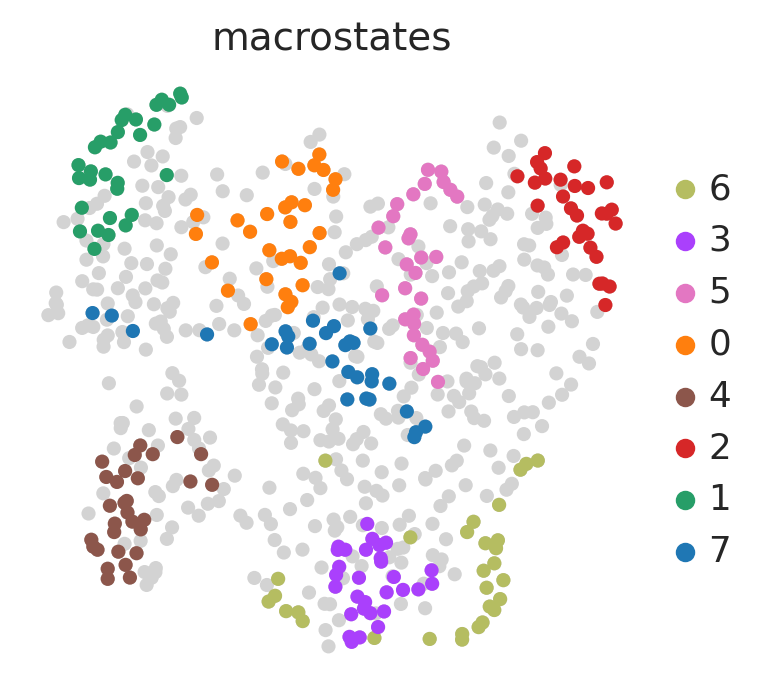

In [63]:
with sns.axes_style("white"):
    scv.settings.figdir = fig_path
    g.plot_macrostates(discrete=True, legend_loc='right', save='macrostates.pdf')

### Choose 4, 2 and 6 as endpoints

In [46]:
terminal_states = ['4', '6', '2']

In [47]:
g.set_terminal_states_from_macrostates(
    terminal_states
)

In [48]:
g._set_initial_states_from_macrostates(
    ['0']
)

In [49]:
g.rename_terminal_states({'4': "CM", "6": "vSMC", "2": "FB/SMC"})

In [50]:
g.compute_absorption_probabilities(solver='gmres', use_petsc=True)

  0%|          | 0/3 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 


/home/icb/laura.martens/miniconda3/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


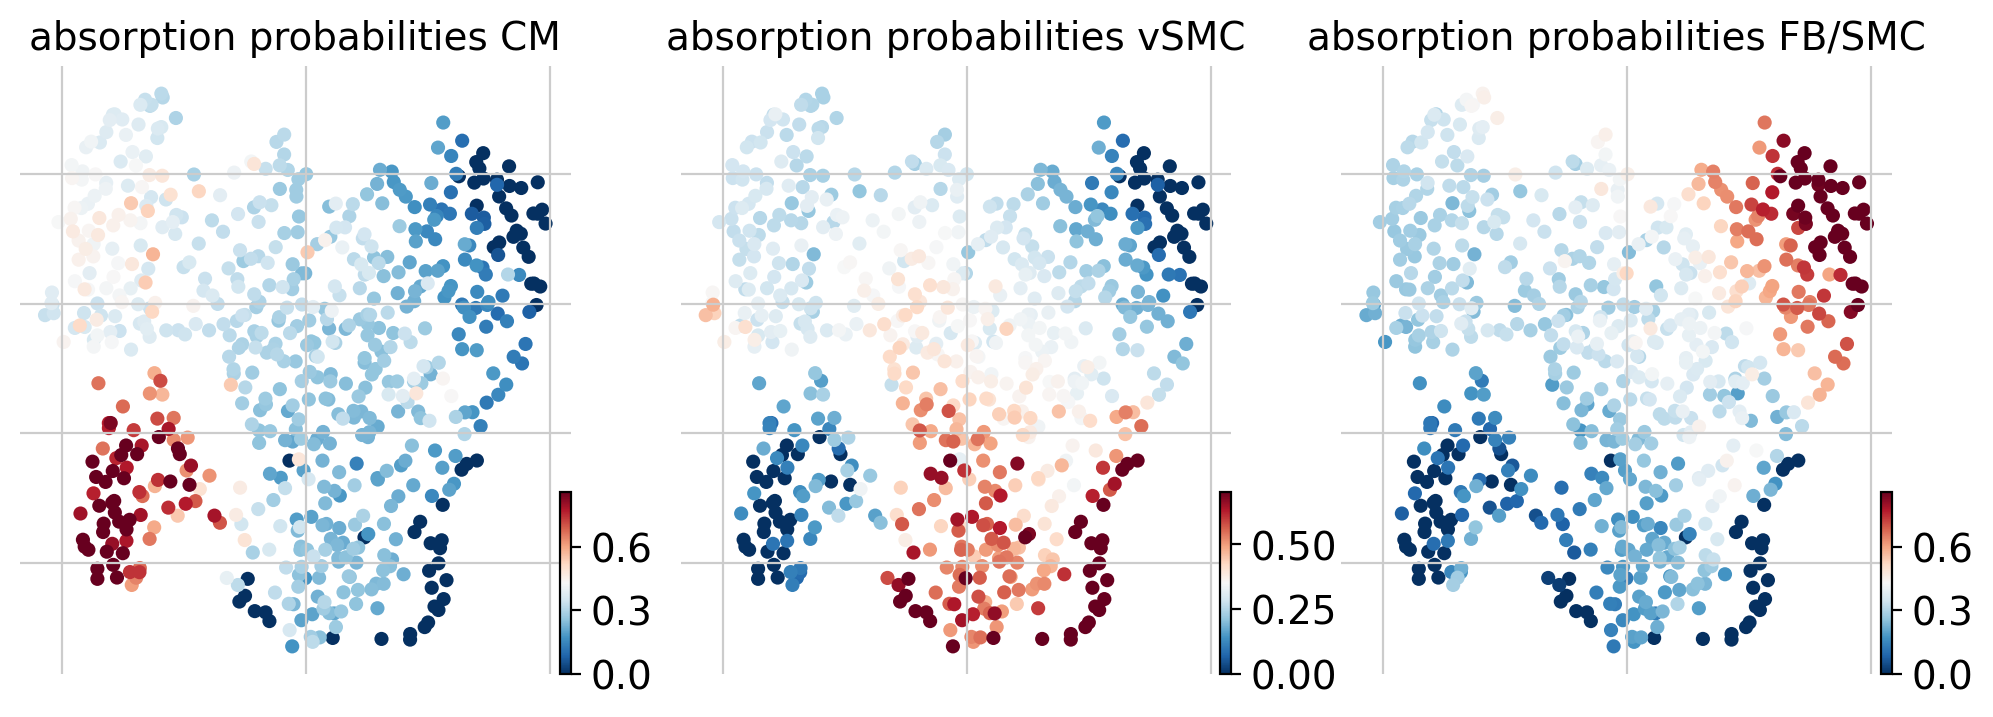

In [51]:
g.plot_absorption_probabilities(same_plot=False, cmap='RdBu_r')

In [52]:
g.write(os.path.join(data_path, 'cellrank', 'g_epicardial.pickle'))

## Plot absorption probabilities

In [53]:
terminal_states = ["CM","vSMC","FB/SMC"]

In [54]:
for ts in terminal_states:
    adata_epi.obs[ts] = g.adata.obsm['to_terminal_states'][ts].X

/home/icb/laura.martens/miniconda3/envs/cellrank/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:452: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(


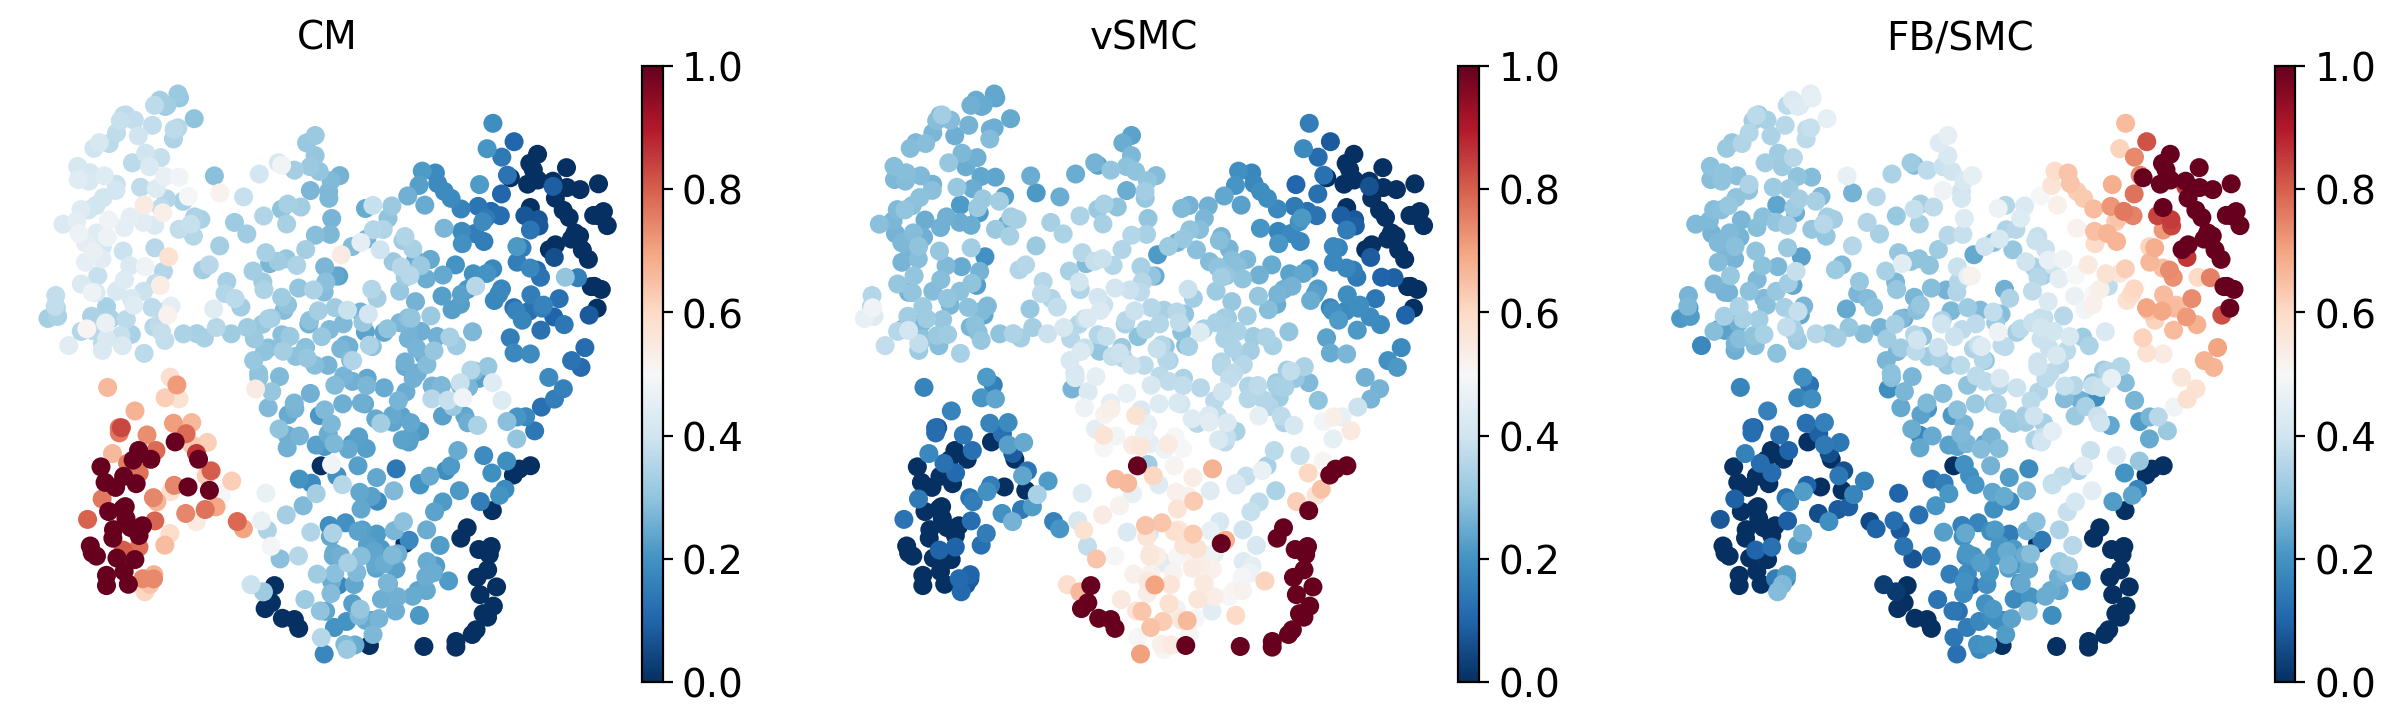

In [66]:
sc.pl.umap(adata_epi, color=terminal_states, save='absorption_probabilities_epi.pdf')

## Plot violin

In [74]:
order = ['0', '7', '5', '2', '3', '4', '6', '1']

In [ ]:
for ts in terminal_states:
    ax = sc.pl.violin(adata_epi, keys=ts, groupby='leiden_sub', show=False, order=order)
    plt.ylabel(f'Absorption probability\n{ts}')
    ts = ts.replace('/', '_')
    plt.savefig(os.path.join(fig_path, f'violin_epi_{ts}.pdf'))

## Plot violin gene expression

In [73]:
violin_info = pd.read_excel(
    '/lustre/groups/ml01/workspace/laura.martens/moretti_colab/transfer_data/Plots_epi_subclustering.xlsx',
    sheet_name="Violin"
)

In [ ]:
for gene in violin_info.Genes.dropna():
    sc.pl.violin(adata_epi, 
                 keys=gene, 
                 groupby='leiden_sub', 
                 layer='log_counts',
                 order=order,
                 save=gene
                )

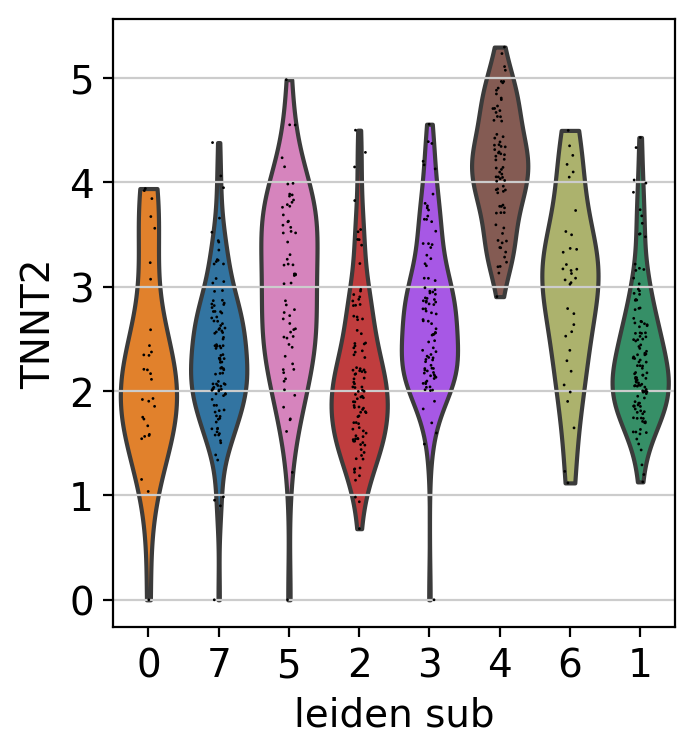

In [76]:
sc.pl.violin(adata_epi, 
             keys='TNNT2', 
             groupby='leiden_sub', 
             layer='log_counts',
             order=order,
             save='TNNT2'
            )

In [ ]:
dfs = {}
for lineage in terminal_states:
    print(lineage)
    df = g.compute_lineage_drivers(lineages=[lineage], cluster_key='leiden_sub', method='perm_test', n_jobs=-1)
    genes = df.sort_values(f'{lineage}_corr', ascending=False).index
    sc.pl.umap(adata_sub_act, color=genes[:12], save=f'gene_activity_drivers_{lineage}.pdf', cmap=my_cmap)
    dfs.update({lineage: df})

In [141]:
g.adata = get_chromvar(adata_epi)

CM


  0%|          | 0/1000 [00:00<?, ?permutation/s]

ERROR: Unable to duplicate function call using shadow `anndata.AnnData` object. Reason: `Lengths must match to compare`


/home/icb/laura.martens/miniconda3/envs/cellrank/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:452: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(


KeyError: 'Could not find key TCF12(var.2) in .var_names or .obs.columns.'

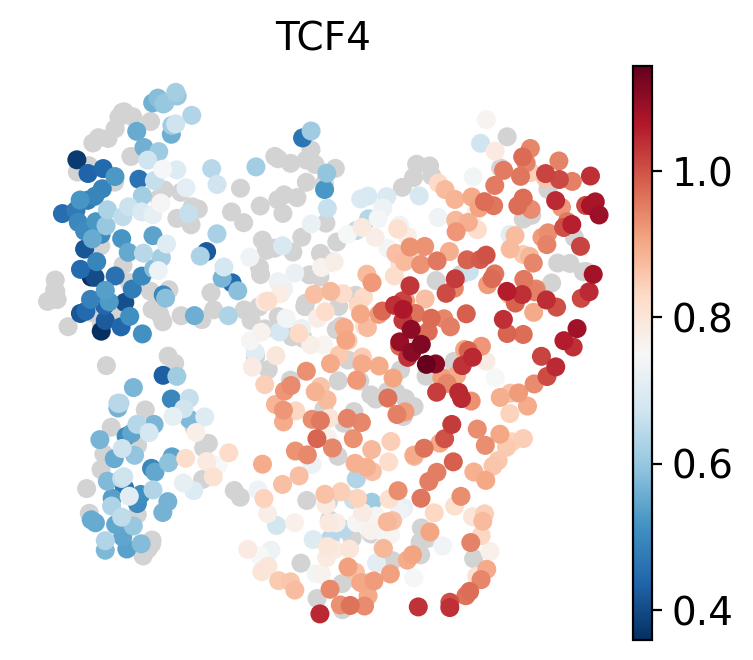

In [142]:
dfs = {}
for lineage in terminal_states:
    print(lineage)
    df = g.compute_lineage_drivers(lineages=[lineage], cluster_key='leiden_sub', method='perm_test', n_jobs=-1)
    genes = df.sort_values(f'{lineage}_corr', ascending=False).index
    sc.pl.umap(g.adata, color=genes[:12], cmap='RdBu_r') #, save=f'gene_activity_drivers_{lineage}.pdf'
    dfs.update({lineage: df})

# Compute paga graph

In [55]:
from utils import paga_path
def plot_paga(adata, paths, genes, normalize_to_zero_one=True, save=None, **kwargs):
    fig, axs = plt.subplots(ncols=len(paths), figsize=(5*len(paths), 0.23*len(genes)), gridspec_kw={'wspace': 0.05, 'left': 0.12})
    plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
    data_dict = {}
    for ipath, (descr, path) in enumerate(paths):
        adata.obs['dpt_pseudotime'] = adata.obs[descr]
        adata.obs['Absorption probability'] = adata.obs[descr]
        ax, data = paga_path(
                adata, path, genes, #[descr]
                show_node_names=False,
                ax=axs[ipath],
                ytick_fontsize=12,
                left_margin=0.15,
                n_avg=50,
                annotations=['Absorption probability'],
                show_yticks=True if ipath==0 else False,
                groups_key='leiden_sub',
                color_maps_annotations={'Absorption probability': 'viridis'},
                title='{} path'.format(descr),
                show=False,
                normalize_to_zero_one=normalize_to_zero_one,
            **kwargs
            )
        if save:
            fig.savefig(os.path.join(fig_path, save), bbox_inches='tight')
        data_dict.update({descr + '_'.join(path): data})
    return data_dict

In [57]:
adata_paga = adata_epi.copy()
adata_paga.X = adata_epi.layers['log_counts']

In [58]:
sc.tl.paga(adata_paga, groups="leiden_sub")

/home/icb/laura.martens/miniconda3/envs/cellrank/lib/python3.9/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


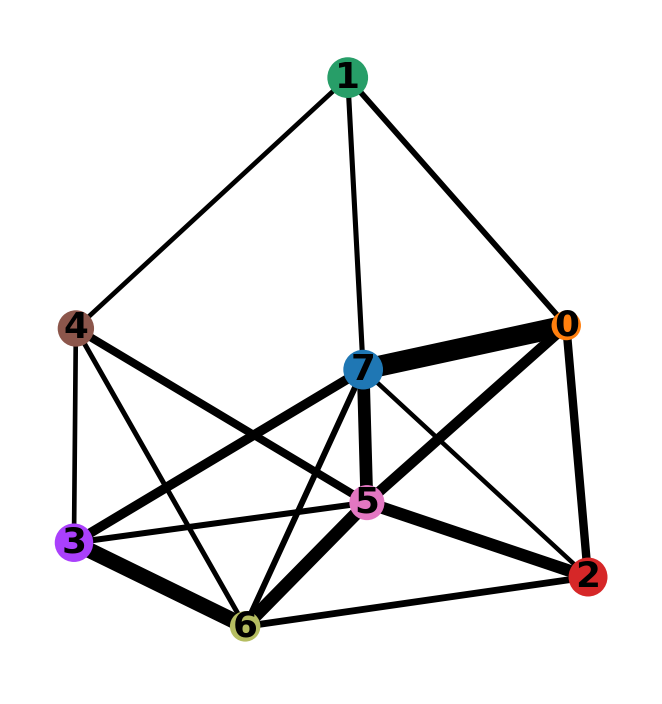

In [59]:
sc.pl.paga(adata_paga, threshold=0.2)


## Plot gene expression along path

In [60]:
paths = [('CM', ['0', '7', '5', '4']),
         ('CM', ['0', '7', '3', '4']),
         ('vSMC', ['0', '7', '5','6']),
         ('vSMC', ['0', '7', '3','6']),
         ('FB/SMC', ['0', '7', '5', '2'])]



/tmp/ipykernel_269693/2276973522.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dpt_pseudotime'] = adata.obs[descr]
/lustre/groups/ml01/code/laura.martens/epicardiods_analysis/notebooks/utils.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/lustre/groups/ml01/code/laura.martens/epicardiods_analysis/notebooks/utils.py:456: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


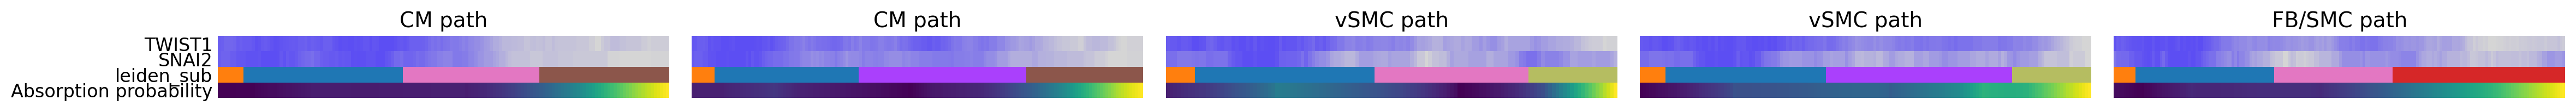

In [61]:
_ = plot_paga(
    adata_paga[adata_paga.obs['atac_match'] ==1], 
    paths, 
    markers_exp, 
    normalize_to_zero_one=True, 
    color_map=my_cmap, 
    show_colorbar=False, 
    return_data=True, 
    save='paga_path_expression.pdf'
)

/tmp/ipykernel_269693/2276973522.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dpt_pseudotime'] = adata.obs[descr]
/lustre/groups/ml01/code/laura.martens/epicardiods_analysis/notebooks/utils.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/lustre/groups/ml01/code/laura.martens/epicardiods_analysis/notebooks/utils.py:456: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


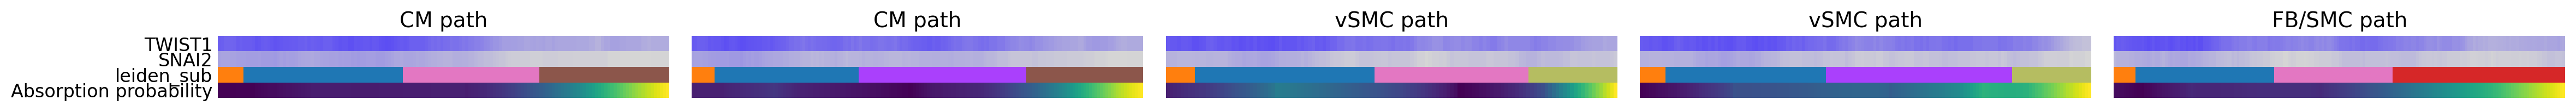

In [62]:
_ = plot_paga(
    adata_paga[adata_paga.obs['atac_match'] ==1], 
    paths, 
    markers_exp, 
    normalize_to_zero_one=False, 
    color_map=my_cmap, 
    show_colorbar=False, 
    return_data=True, 
    save='paga_path_expression_unscaled.pdf'
)

## Plot imputed gene activity along path

In [63]:
test_act = get_act(test, imputed=True, fill_value=0)
test_act = test_act[test_act.obs['atac_match'] ==1]

In [64]:
markers_act = pd.concat([markers_act , pd.Series([
"CSPG4"])])

/tmp/ipykernel_269693/2276973522.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dpt_pseudotime'] = adata.obs[descr]
/lustre/groups/ml01/code/laura.martens/epicardiods_analysis/notebooks/utils.py:409: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/lustre/groups/ml01/code/laura.martens/epicardiods_analysis/notebooks/utils.py:456: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


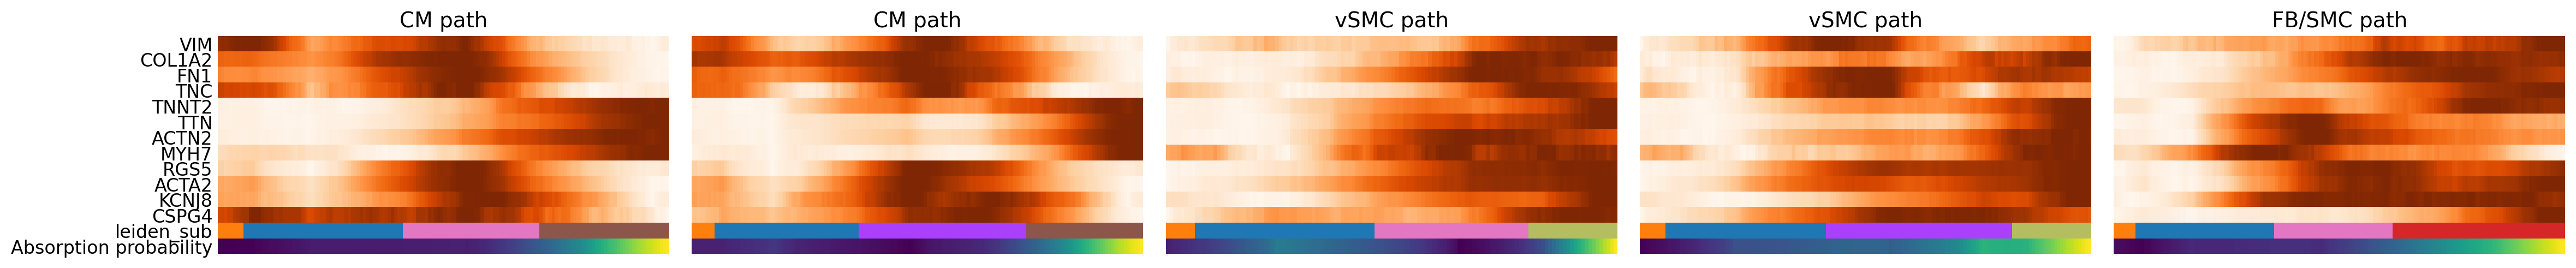

In [65]:
data = plot_paga(
    test_act, 
    paths, 
    markers_act, 
    normalize_to_zero_one=True, 
    show_colorbar=False, 
    return_data=True, 
    color_map='Oranges',
    save='paga_path_activity.pdf'
)


## Plot color scale

In [127]:
import matplotlib as mpl
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    top = 0.35
    bottom = 0.15
    figh = top + bottom + (nrows + (nrows - 1) * 0.1) * 0.22

    figh=1
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - top / figh, bottom= bottom / figh,
                        left=0.2, right=0.99)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=name)
        # ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
        #         transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list
    return ax 

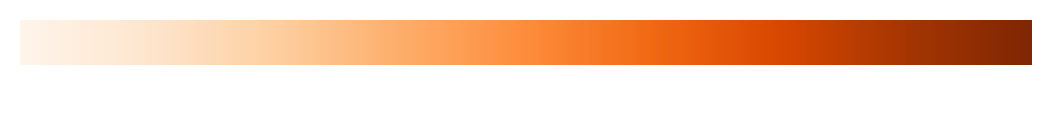

In [129]:
ax = plot_color_gradients('Sequential',
                     [mpl.colormaps['Oranges']])
plt.savefig(os.path.join(fig_path, 'oranges_color_map.pdf'))

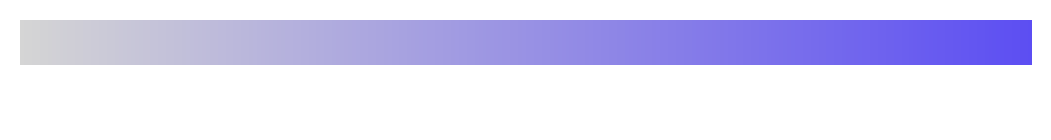

In [130]:
ax = plot_color_gradients('Sequential',
                     [my_cmap])
plt.savefig(os.path.join(fig_path, 'purples_color_map.pdf'))